In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.conv_ae_1D import *
import torch
import random
from torchvision.transforms import transforms as T, Lambda
from pathlib import Path
from config import *
from utils import *
from conv_utils import *

import numpy as np
import platform
import json

architecture='conv_ae1D'

In [2]:
exp_dict = exp_name_folders(path =esa_exploration, architecture=architecture)
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_02-09-23:14:38:56_conv_ae1D_sl_16_run3
num selection:1 - exp name:third_wheel_system_sl_40
num selection:2 - exp name:4_wheel_system_sl_40


In [3]:
select_exp = '1'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: third_wheel_system_sl_40


In [4]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /home/roberto/Documents/backup_rob/repo/esa_fdir/time_series_anomaly_detection/model_results/esa_exploration/conv_ae1D/third_wheel_system_sl_40/summary.csv


In [5]:
summary.reset_index().head()

,index,Unnamed: 0,name,train_loss,val_loss
0,39,1,"trainCONVAE1D_8e191_00003_3_activation=Elu,bat...",0.001875,0.000200
1,38,22,"trainCONVAE1D_8e191_00004_4_activation=Elu,bat...",0.001875,0.000200
2,37,19,"trainCONVAE1D_8e191_00029_29_activation=Elu,ba...",0.001904,0.000201
3,36,11,"trainCONVAE1D_8e191_00028_28_activation=Elu,ba...",0.002241,0.000433
4,35,23,"trainCONVAE1D_8e191_00038_38_activation=Elu,ba...",0.002034,0.000488


In [6]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'activation': 'Elu', 'batch_size': 500, 'dilation': 1, 'epochs': 200, 'filter_num': 128, 'kernel_size': 5, 'lr': 0.0009, 'lr_patience': 5, 'n_layers': 1, 'pool': 'False', 'seq_in_length': 40}


In [7]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path))
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
if platform.node()=='leonard':
    device='cpu'
else:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
model = CONV_AE1D(in_channel=params_conf['in_channel'],  length=params_conf['length']
                  , kernel_size=params_conf['kernel_size'], filter_num=params_conf['filter_num'],
                 n_layers=params_conf['n_layers'], activation = params_conf['activation']
                  , stride=params_conf['stride'], pool=params_conf['pool']).to(device).float()
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
par_nums = count_parameters(model)
print('number of params', par_nums)

In [25]:
columns_subset=params_conf['columns_subset']
dataset_subset=params_conf['dataset_subset']
cols = cfg.dataset.columns
scaled = cfg.dataset.scaled
train_val_split = cfg.dataset.train_val_split
target = params_conf['target']
sequence_length = params_conf['sequence_length']
out_window = params_conf['sequence_length']
predict = params_conf['predict']

In [26]:
xdf = pd.read_pickle("../data/FIORIRE/dataset_4s/all_2016-2018_clean_4s.pkl")
batch_size = 10
if columns_subset:
    cols = cols[columns_subset]
dataRaw = xdf[cols].dropna()

if dataset_subset:
    dataRaw = dataRaw.iloc[:dataset_subset, :]

df = dataRaw.copy()
x = df.values

if scaled:
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    dfNorm = pd.DataFrame(x_scaled, columns=df.columns)
else:
    dfNorm = pd.DataFrame(x, columns=df.columns)

X_train, X_test, y_train, y_test = train_test_split(dfNorm, dfNorm, \
                                                    train_size=train_val_split\
                                                    , shuffle=False)
df_train = pd.DataFrame(X_train, columns=dfNorm.columns)
df_test = pd.DataFrame(X_test, columns=dfNorm.columns)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

transform = T.Compose([
    T.ToTensor(),
    Lambda(lambda x: x.permute((0, 2, 1))),
    Lambda(lambda x: x.squeeze())
])

train_dataset = Dataset_seq(df_train, target = target, sequence_length = sequence_length,
                            out_window = out_window, prediction=predict,\
                            transform=transform)
train_iter = DataLoader(dataset=train_dataset,\
                        batch_size=batch_size, shuffle=True)

test_dataset = Dataset_seq(df_test, target = target, \
                           sequence_length = sequence_length,
                            out_window = out_window, prediction=predict,\
                           transform=transform)
test_iter = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
num_batch = 10
shift = np.random.randint(len(test_iter.dataset.df_data)-1000)
print(shift)

x = np.zeros((num_batch, sequence_length, len(cols)))
for i in range(num_batch):

    x[i,:,:] = test_iter.dataset.df_data.iloc[shift + i*sequence_length:shift + (i+1)*sequence_length,:]\
    .values
    
x = torch.from_numpy(x).float()
x = x.permute((0, 2, 1)) 

78306


In [28]:
yo = model(x.to(device))

In [29]:
seq_len = sequence_length
par_nums = count_parameters(model)

./figure_results/conv_ae/evaluation/trainCONVAE1D_8e191_00003_3_activation=Elu,batch_size=500,dilation=1,epochs=200,filter_num=128,kernel_size=5,lr=0.0009,lr_patience_2023-02-13_18-56-16_61920/shift_0/1/


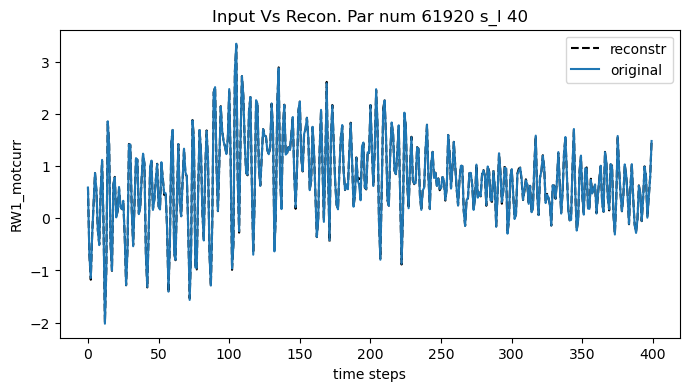

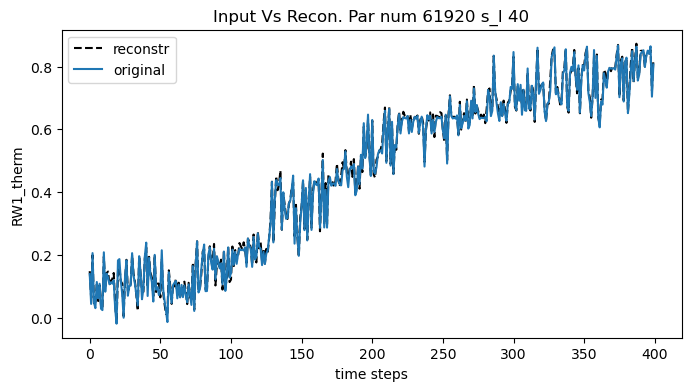

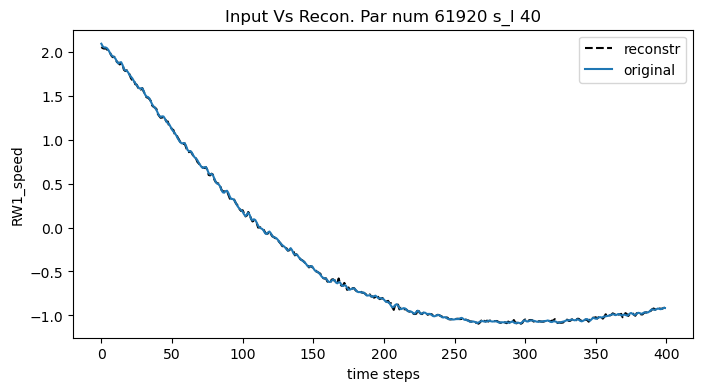

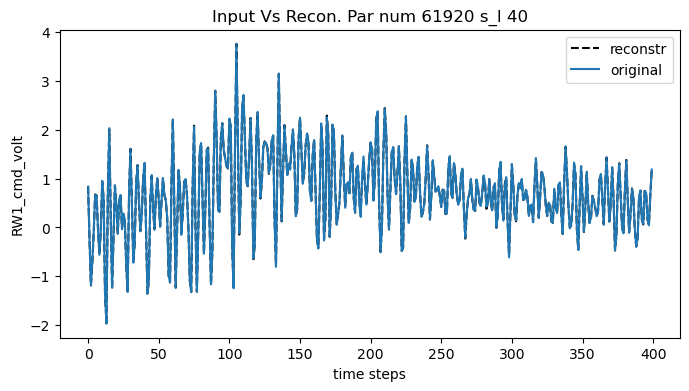

In [30]:
shift = 0
num_batch = 1
save = False
path = './figure_results/conv_ae/evaluation/{}_{}/shift_{}/{}/'.format(model_name, par_nums
                                                                        , shift, num_batch)
print(path)

for i in range(x.shape[1]):
    fig, ax = plt.subplots(1,1, figsize=(8,4))
    

    ax.plot(yo[:,i,:].flatten().to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax.plot(x[:,i,:].flatten().to("cpu").detach().numpy(), label ='original')
    #x_i = x[:,i,:].flatten()
    #y_o = yo[:,i,:].flatten()

    #loss_u = torch.nn.L1Loss(reduction='none')(y_o.to("cpu"), x_i)
    #loss_u = moving_average(loss_u.to("cpu").detach().numpy(), seq_len)
    
    

    #ax.plot(loss_u, label =' mean abs err {} seq. len. conv.'.format(seq_len))
    ax.set_xlabel('time steps')
    ax.set_ylabel('{}'.format(cols[i]))
    ax.set_title('Input Vs Recon. Par num {} s_l {}'\
                    .format(par_nums, seq_len))

    ax.legend()